In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [37]:
import torch
torch.cuda.set_device(0)
from torch import nn
from fastai import *
from fastai.conv_learner import *
from pathlib import Path
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt 
import matplotlib.image as im

### Load Data

In [11]:
PATH = Path('/mnt/data/extracts/lsun/')
IMG_PATH = PATH/'bedroom'
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [14]:
sample = True
files = PATH.glob('bedroom/**/*.jpg')
if sample:
    CSV_PATH = PATH/'files_sample.csv'
else:
    CSV_PATH = PATH/'files.csv'

with CSV_PATH.open('w') as fo:
    for f in files:
        if (random.random() < 0.1 and sample) or not sample: 
            fo.write(f'{f.relative_to(IMG_PATH)},0\n')

In [54]:
sz = 64
tfms = tfms_from_stats(inception_stats, sz)
md = ImageClassifierData.from_csv(TMP_PATH, IMG_PATH, CSV_PATH, tfms=tfms)

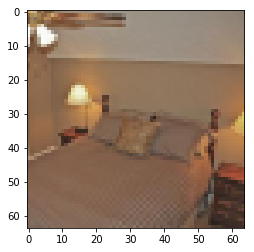

In [55]:
x, y = next(iter(md.trn_dl))
plt.imshow(np.squeeze(md.trn_ds.denorm(x[0])))

### Architecture

#### Discriminator Block

In [32]:
def calc_padding(ni, no, ks, stride):
    return ((no - 1) * stride + ks - ni)//2

In [112]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks):
        super(ConvBlock, self).__init__()
        self.c1 = nn.Conv2d(ni, 2*ni, ks, stride=1)
        self.c2 = nn.Conv2d(2*ni, no, ks, stride=2, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(no)
        self.layers = [self.c1, self.c2, self.relu, self.bn]
        
    def forward(self, x):
        x = nn.Sequential(*self.layers)(x)
        return x

In [162]:
class DCGAN_D(nn.Module):
    def __init__(self):
        super(DCGAN_D, self).__init__()
        self.cb1 = ConvBlock(3, 20, 3)
        self.cb2 = ConvBlock(20, 40, 3)
        self.cb3 = ConvBlock(40, 80, 3)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.layers = [self.cb1, self.cb2, self.cb3, self.pool]
    
    def forward(self, x):
        x = nn.Sequential(*self.layers)(x)
        return x.mean()

### Generator Block

In [226]:
bs, nz = 64, 400

In [210]:
def create_noise(bs): return V(torch.zeros(bs, nz, 1, 1).normal_(0, 1))

In [227]:
class DeconvBlock(nn.Module):
    def __init__(self, nz):
        super(DeconvBlock, self).__init__()
        self.d1 = nn.ConvTranspose2d(nz, nz // 2, kernel_size=4, stride=1)
        self.d2 = nn.ConvTranspose2d(nz // 2, nz // 2, kernel_size=4, stride=1)
        self.th = nn.Tanh()
        
    def forward(self, x):
        x = self.d1(x)
        x = self.d2(x)
        x = self.th(x)
        return x

In [228]:
class DCGAN_G(nn.Module):
    def __init__(self, nz):
        super(DCGAN_G, self).__init__()
        self.db1 = DeconvBlock(nz)
        self.db2 = DeconvBlock(nz // 2)
        self.db3 = DeconvBlock(nz // 4)
        self.db4 = DeconvBlock(nz // 8)
        self.db5 = DeconvBlock(nz // 16)
        self.db6 = DeconvBlock(nz // 32)
        self.db7 = DeconvBlock(nz // 64)
        
    def forward(self, x):
        pdb.set_trace()
        x = self.db1(x)
        x = self.db2(x)
        x = self.db3(x)
        x = self.db4(x)
        x = self.db5(x)
        x = self.db6(x)
        x = self.db7(x)
        return x

In [229]:
x, y = next(iter(md.trn_dl))

In [124]:
np.max(to_np(x[0]))

0.9990915

In [230]:
model = to_gpu(DCGAN_G(nz))
crit = F.softmax
learn = Learner(md, SingleModel(model), opt_fn=optim.Adam, crit=crit)

In [231]:
model(create_noise(bs))

> <ipython-input-228-ec593137b785>(14)forward()
-> x = self.db1(x)
(Pdb) n
> <ipython-input-228-ec593137b785>(15)forward()
-> x = self.db2(x)
(Pdb) 
> <ipython-input-228-ec593137b785>(16)forward()
-> x = self.db3(x)
(Pdb) 
> <ipython-input-228-ec593137b785>(17)forward()
-> x = self.db4(x)
(Pdb) 
> <ipython-input-228-ec593137b785>(18)forward()
-> x = self.db5(x)
(Pdb) 
> <ipython-input-228-ec593137b785>(19)forward()
-> x = self.db6(x)
(Pdb) 
> <ipython-input-228-ec593137b785>(20)forward()
-> x = self.db7(x)
(Pdb) 
> <ipython-input-228-ec593137b785>(21)forward()
-> return x
(Pdb) x.size()
torch.Size([64, 3, 43, 43])
(Pdb) q


BdbQuit: 

In [150]:
learn.fit(0.001, 1)

  0%|          | 0/380 [00:00<?, ?it/s]> <ipython-input-144-5e858d24d504>(10)forward()
-> x = self.d1(x)
(Pdb) l
  5  	        self.d2 = nn.ConvTranspose2d(3, 3, kernel_size=3, stride=2)
  6  	        self.th = nn.Tanh()
  7  	
  8  	    def forward(self, x):
  9  	        pdb.set_trace()
 10  ->	        x = self.d1(x)
 11  	        x = self.d2(x)
 12  	        x = self.th(x)
 13  	        return x
[EOF]
(Pdb) x.size()
torch.Size([64, 3, 64, 64])

(Pdb) q


BdbQuit: 